In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import os
from config import config_dict
import itertools
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

pd.options.display.max_columns=100

In [2]:
# Make directory for saving figures
if not os.path.exists('figs/s1'):
    os.makedirs('figs/s1')

# A-D. Cycle feature distributions from example recording

In [3]:
# Load dataframe of cycle feature statistics for each shank
df_shanks = pd.read_csv(config_dict['processed_path'] + 'df_shanks_stats.csv', index_col=0)
df_shanks = df_shanks[df_shanks['burst_type']==0].reset_index()

# Load lfp
shank_idx = 0
rat, sess, sh, Fs, elec = df_shanks.loc[shank_idx, ['rat', 'sess', 'sh', 'Fs', 'elec']]

In [4]:
file_shapedf = config_dict['mat_path'] + '/' + rat + '/' + sess + '/' + str(sh) + '/cycle_by_cycle_shape.csv'
df_shape = pd.read_csv(file_shapedf, index_col=0)
df_shape = df_shape[df_shape['is_burst0']].reset_index(drop=True)
df_shape['period_ms'] = df_shape['period'] / Fs * 1000
df_shape['mv_amp'] = df_shape['volt_amp'] / 1000

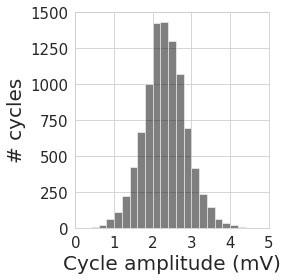

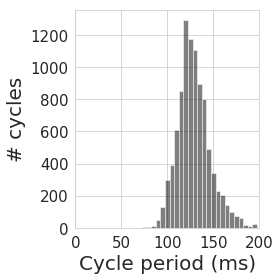

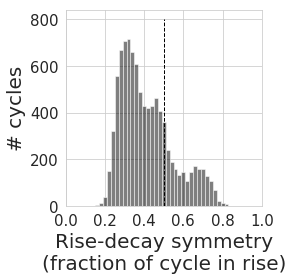

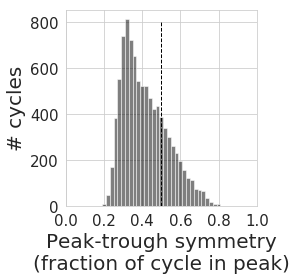

In [5]:
feats_plot = ['mv_amp', 'period_ms', 'time_rdsym', 'time_ptsym']
feat_bins = {'mv_amp': np.arange(0, 5, .2),
             'period_ms': np.arange(2.5, 200, 5),
             'time_rdsym': np.arange(.01, 1, .02),
             'time_ptsym': np.arange(.01, 1, .02)}
feat_xlim = {'mv_amp': (0,5),
             'period_ms': (0,200),
             'time_rdsym': (0,1),
             'time_ptsym': (0,1)}
feat_xticks = {'mv_amp': np.arange(6),
             'period_ms': np.arange(0,250,50),
             'time_rdsym': np.arange(0,1.2,.2),
             'time_ptsym': np.arange(0,1.2,.2)}
feat_letters = {'mv_amp': 'A',
                'period_ms': 'B',
                'time_rdsym': 'C',
                'time_ptsym': 'D'}
feat_xlabel = {'mv_amp': 'Cycle amplitude (mV)',
             'period_ms': 'Cycle period (ms)',
             'time_rdsym': 'Rise-decay symmetry\n(fraction of cycle in rise)',
             'time_ptsym': 'Peak-trough symmetry\n(fraction of cycle in peak)'}

for feat in feats_plot:
    plt.figure(figsize=(4, 4))
    plt.hist(df_shape[feat], bins=feat_bins[feat], color='k', alpha=.5)
    if feat in ['time_rdsym', 'time_ptsym']:
        plt.plot([.5, .5], [0, 800], 'k--')
    plt.xticks(feat_xticks[feat])
    plt.xlim(feat_xlim[feat])
    plt.xlabel(feat_xlabel[feat])
    plt.ylabel('# cycles')
    plt.tight_layout()
    plt.savefig('figs/s1/{:s}.png'.format(feat_letters[feat]))

# E-G. Correlations between cycle features, within 1 recording

In [6]:
# Choose a shank
shank_idx = 115 # Arbitrary choice that is representative
rat, sess, sh, Fs = df_shanks.loc[shank_idx, ['rat', 'sess', 'sh', 'Fs']]
file_shapedf = config_dict['mat_path'] + rat + '/' + sess + '/' + str(sh) + '/cycle_by_cycle_shape.csv'
df_shape = pd.read_csv(file_shapedf, index_col=0)
df_shape = df_shape[df_shape['is_burst0']==1].reset_index(drop=True)
df_shape['mv_amp'] = df_shape['volt_amp'] / 1000
df_shape['ms_period'] = df_shape['period'] / Fs * 1000

In [7]:
# Look at correlations between main features
feats = ['mv_amp', 'ms_period', 'time_rdsym', 'time_ptsym']
for feat_pair in itertools.combinations(feats, 2):
    r, p = stats.spearmanr(df_shape[feat_pair[0]], df_shape[feat_pair[1]])
    print('{:s} ~ {:s}, r = {:.2f}, p = {:.0E}'.format(feat_pair[0], feat_pair[1], r, p))

mv_amp ~ ms_period, r = 0.06, p = 1E-05
mv_amp ~ time_rdsym, r = -0.03, p = 9E-03
mv_amp ~ time_ptsym, r = -0.03, p = 3E-02
ms_period ~ time_rdsym, r = 0.06, p = 7E-06
ms_period ~ time_ptsym, r = -0.01, p = 3E-01
time_rdsym ~ time_ptsym, r = -0.21, p = 4E-54


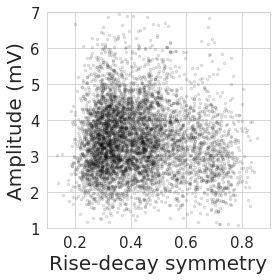

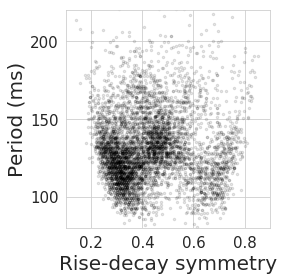

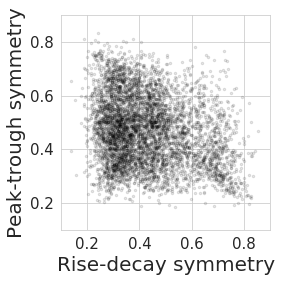

In [8]:
# Plot correlation scatters
pltfmt = {'letter': {'mv_amp': 'E',
                     'ms_period': 'F',
                     'time_ptsym': 'G'},
          'lim': {'mv_amp': (1, 7),
                  'ms_period': (80, 220),
                  'time_ptsym': (.1, .9)},
          'ticks': {'mv_amp': np.linspace(1, 7, 7),
                  'ms_period': np.linspace(50, 250, 5),
                  'time_ptsym': np.linspace(0, 1, 6)},
          'label': {'mv_amp': 'Amplitude (mV)',
                  'ms_period': 'Period (ms)',
                  'time_ptsym': 'Peak-trough symmetry'}
         }
other_feats = ['mv_amp', 'ms_period', 'time_ptsym']
for feat in pltfmt['lim'].keys():
    plt.figure(figsize=(4, 4))
    plt.plot(df_shape['time_rdsym'], df_shape[feat], 'k.', ms=5, alpha=.1)
    plt.xticks(np.linspace(0, 1, 6))
    plt.yticks(pltfmt['ticks'][feat])
    plt.xlim((.1, .9))
    plt.ylim(pltfmt['lim'][feat])
    plt.xlabel('Rise-decay symmetry')
    plt.ylabel(pltfmt['label'][feat])
    plt.tight_layout()
    plt.savefig('figs/s1/{:s}.png'.format(pltfmt['letter'][feat]))